Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
from glob import glob
import fnmatch
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
# If you are using google colab then uncommnet this code
# from google.colab import drive
# drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and \test images
# train_path = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
# test_path = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/"

train_path = "./Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
test_path = "./Skin cancer ISIC The International Skin Imaging Collaboration/Test/"

data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [6]:
total_count = image_count_test + image_count_train
print("Total number of images in dataset", total_count)

Total number of images in dataset 2357


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180
image_size = (img_height, img_width)

Use 80% of the images for training, and 20% for validation.

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

In [11]:
temp_class = []
temp_dict = {}
for images, labels in train_ds:
  for i, val in enumerate(class_names):
    if class_names[labels[i]] not in temp_class:
      temp_class.append(class_names[labels[i]])
      temp_dict[class_names[labels[i]]] = images[i].numpy().astype("uint8")
  if len(temp_class) == len(class_names):
    break

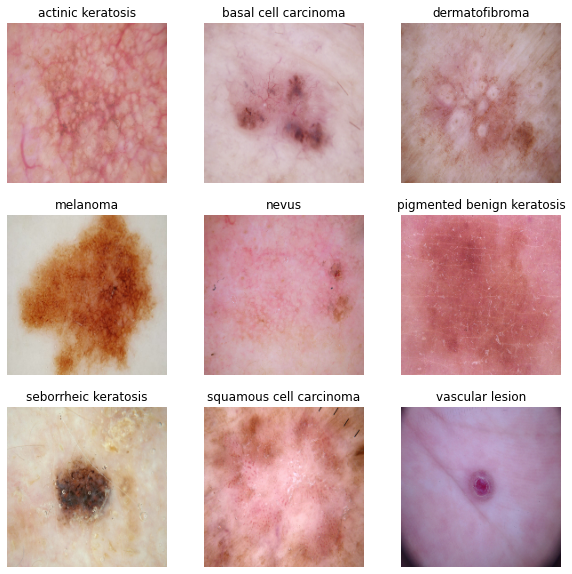

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(temp_dict[class_names[i]])
  plt.title(class_names[i])
  plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
# input shape of (img_height, img_width, 3)
input_shape = image_size + (3,)
num_classes = len(class_names)

In [16]:
### Your code goes here
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 128)       0

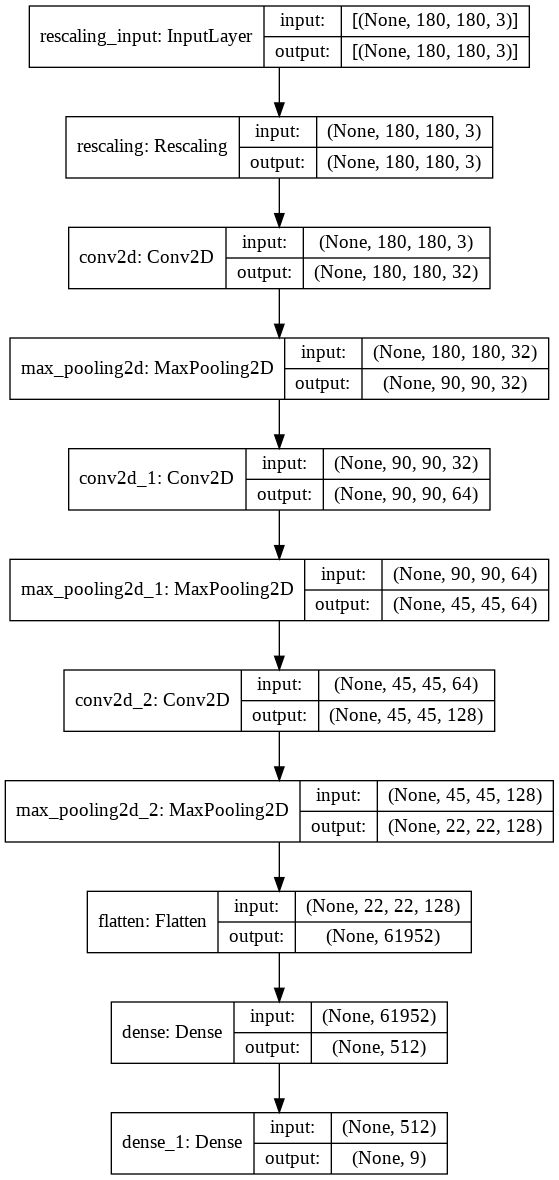

In [19]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

### Train the model

In [21]:
%%time
epochs = 20
history_1 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 83ms/step - loss: 1.3292 - accuracy: 0.5402 - val_loss: 1.3945 - val_accuracy: 0.4989
Epoch 2/20
56/56 [==============================] - 5s 82ms/step - loss: 1.2253 - accuracy: 0.5709 - val_loss: 1.3951 - val_accuracy: 0.5213
Epoch 3/20
56/56 [==============================] - 5s 82ms/step - loss: 1.1492 - accuracy: 0.5926 - val_loss: 1.3375 - val_accuracy: 0.5593
Epoch 4/20
56/56 [==============================] - 5s 82ms/step - loss: 1.0418 - accuracy: 0.6261 - val_loss: 1.3886 - val_accuracy: 0.5369
Epoch 5/20
56/56 [==============================] - 5s 81ms/step - loss: 0.9862 - accuracy: 0.6523 - val_loss: 1.4479 - val_accuracy: 0.5324
Epoch 6/20
56/56 [==============================] - 5s 81ms/step - loss: 0.8946 - accuracy: 0.6819 - val_loss: 1.5464 - val_accuracy: 0.5503
Epoch 7/20
56/56 [==============================] - 5s 81ms/step - loss: 0.7988 - accuracy: 0.7121 - val_loss: 1.5885 - val_accuracy: 0.5436
Epoch 8/20
56

### Visualizing training results

In [1]:
# Function to visualize training result
def visualize_train_result(history, epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()  

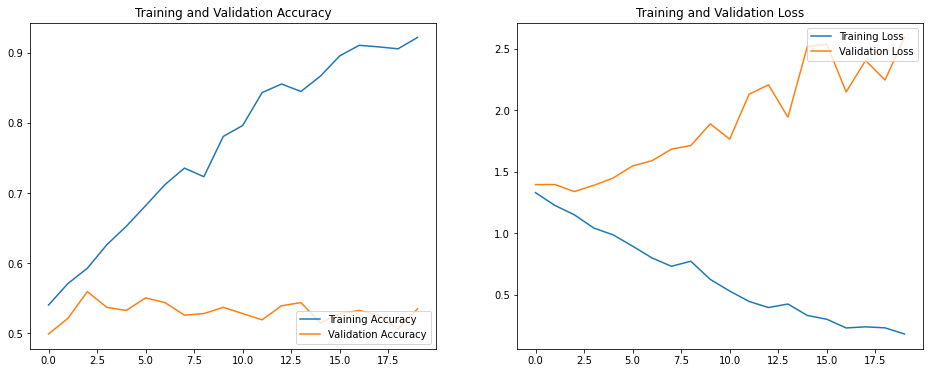

In [23]:
visualize_train_result(history_1, epochs)

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around appro 50% accuracy on the validation set.


### Findings

### Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas model is performing poor on validation set (model has achieved only around 50% accuracy on the validation set). Also, the difference in accuracy between training and validation accuracy is sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

To overcome overfitting in the training process use **data augumentation** strategy.

## Data augmentation

Data augmentation is a technique used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning model.

In [24]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize augmented examples by applying data augmentation to the same image several times:

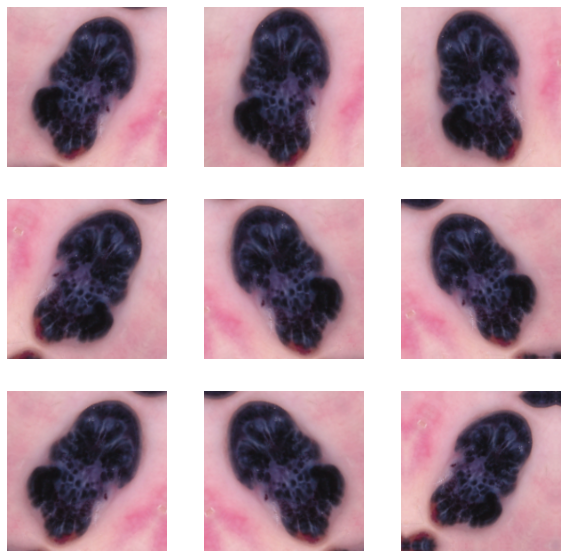

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model


In [26]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
### Your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.20),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.20),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.20),

  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [28]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 64)       

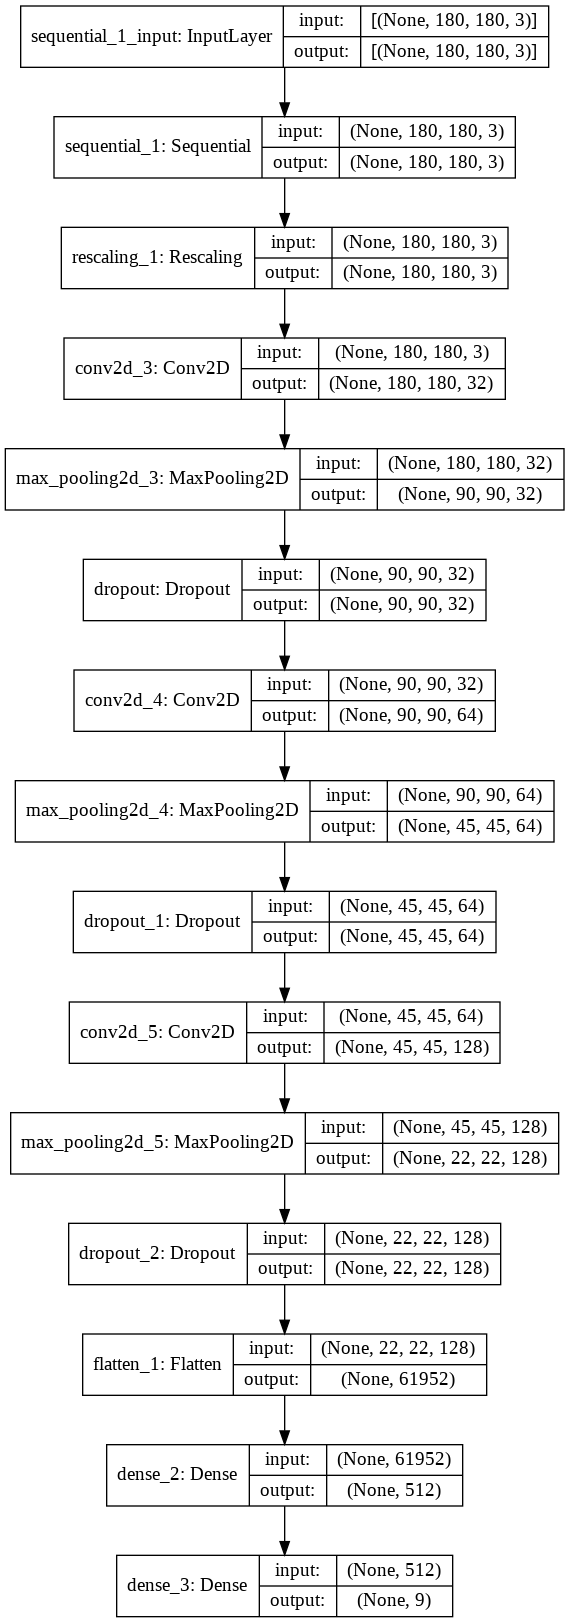

In [30]:
plot_model(model, show_shapes=True, show_layer_names=True)

### Training the model

In [31]:
%%time
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history_2 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 99ms/step - loss: 3.1006 - accuracy: 0.1970 - val_loss: 2.0145 - val_accuracy: 0.2327
Epoch 2/20
56/56 [==============================] - 5s 94ms/step - loss: 1.9401 - accuracy: 0.2907 - val_loss: 1.8444 - val_accuracy: 0.3378
Epoch 3/20
56/56 [==============================] - 5s 94ms/step - loss: 1.7297 - accuracy: 0.3638 - val_loss: 1.6512 - val_accuracy: 0.4004
Epoch 4/20
56/56 [==============================] - 5s 94ms/step - loss: 1.6571 - accuracy: 0.4068 - val_loss: 1.6155 - val_accuracy: 0.4094
Epoch 5/20
56/56 [==============================] - 5s 94ms/step - loss: 1.5698 - accuracy: 0.4191 - val_loss: 1.6370 - val_accuracy: 0.3960
Epoch 6/20
56/56 [==============================] - 5s 95ms/step - loss: 1.5565 - accuracy: 0.4308 - val_loss: 1.5971 - val_accuracy: 0.4206
Epoch 7/20
56/56 [==============================] - 5s 95ms/step - loss: 1.5312 - accuracy: 0.4392 - val_loss: 1.6268 - val_accuracy: 0.4228
Epoch 8/20
56

### Visualizing the results

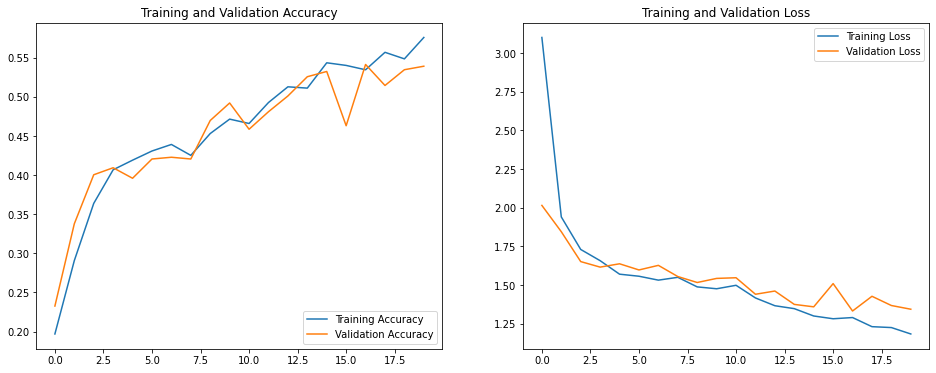

In [32]:
# call function to plot graph
visualize_train_result(history_2, epochs)

### Findings

#### In the plots above, the training and validation accuracy is increasing linearly over time. But model is performing poor training and validation set (model has achieved only around 57% accuracy on the training set and 53% accuracy on the validation set). 

#### Using dropout we have overcomed problem of overfitting, but model has high bias which is sign of overfitting.


## Let's find the distribution of classes.


### Let's find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [33]:
# define path of training data
temp_path = os.path.join(data_dir_train, '*', '*.jpg')

path_list_1 = [x for x in glob(temp_path)]
lesion_list_new_1 = [os.path.basename(os.path.dirname(y)) for y in glob(temp_path)]

dataframe_dict_new_1 = dict(zip(path_list_1, lesion_list_new_1))
original_df = pd.DataFrame(list(dataframe_dict_new_1.items()),columns = ['Path','Label'])

In [34]:
df_dist = original_df['Label'].value_counts(normalize=True)
df_dist

pigmented benign keratosis    0.206342
melanoma                      0.195623
basal cell carcinoma          0.167932
nevus                         0.159446
squamous cell carcinoma       0.080840
vascular lesion               0.062081
actinic keratosis             0.050916
dermatofibroma                0.042430
seborrheic keratosis          0.034390
Name: Label, dtype: float64

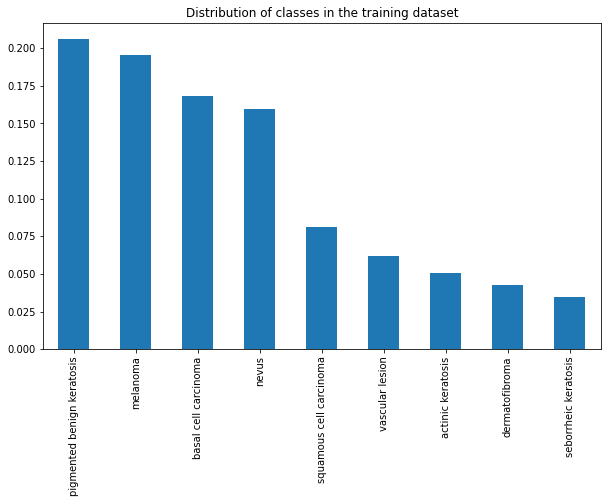

In [35]:
# plt.figure(figsize = (10, 6))
fig, ax = plt.subplots(figsize =(10, 6))
df_dist.plot(kind = 'bar')
plt.title("Distribution of classes in the training dataset")
plt.show()

#### **Findings:**
#### From above class distribution we can see that 
- **`seborrheic keratosis (77 count)`** class has the least number of samples.

- **`pigmented benign keratosis,  melanoma, basal cell carcinoma and nevus`** these classes dominate the data.

#### Rectify the class imbalance
#### Here can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [36]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [37]:
import Augmentor
path_to_training_dataset = train_path
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Deep Learning/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF721B07150>: 100%|██████████| 500/500 [00:23<00:00, 21.07 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Deep Learning/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF721B8FDD0>: 100%|██████████| 500/500 [00:23<00:00, 21.39 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Deep Learning/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF68658C790>: 100%|██████████| 500/500 [00:24<00:00, 20.61 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Deep Learning/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FF6862C9D90>: 100%|██████████| 500/500 [01:41<00:00,  4.93 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Deep Learning/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7FF686288150>: 100%|██████████| 500/500 [01:36<00:00,  5.18 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Deep Learning/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF6862D66D0>: 100%|██████████| 500/500 [00:24<00:00, 20.31 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Deep Learning/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FF6865B9E10>: 100%|██████████| 500/500 [00:52<00:00,  9.54 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Deep Learning/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF683C98150>: 100%|██████████| 500/500 [00:25<00:00, 19.94 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Deep Learning/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF721B2A350>: 100%|██████████| 500/500 [00:24<00:00, 20.57 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [38]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


#### Distribution of augmented data
#### Lets see the distribution of augmented data after adding new images to the original training data.

In [39]:
temp_path = os.path.join(data_dir_train, '*','output', '*.jpg')

path_list = [x for x in glob(temp_path)]
# path_list

In [40]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(temp_path)]
# lesion_list_new

In [41]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

### Let's find the distribution of classes for augumented data.


In [42]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2['Label'].value_counts()

seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
basal cell carcinoma          500
pigmented benign keratosis    500
melanoma                      500
dermatofibroma                500
actinic keratosis             500
nevus                         500
Name: Label, dtype: int64

In [43]:
df_dist2 = df2['Label'].value_counts(normalize=True)
df_dist2

seborrheic keratosis          0.111111
squamous cell carcinoma       0.111111
vascular lesion               0.111111
basal cell carcinoma          0.111111
pigmented benign keratosis    0.111111
melanoma                      0.111111
dermatofibroma                0.111111
actinic keratosis             0.111111
nevus                         0.111111
Name: Label, dtype: float64

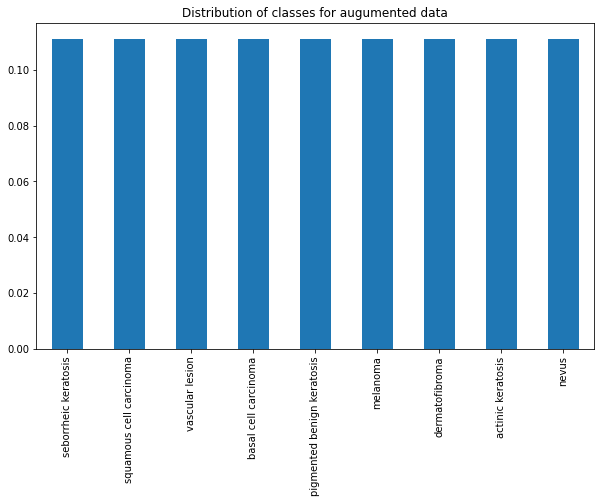

In [44]:
# Lets check distribution of classes for augumented data
plt.figure(figsize = (10, 6))
df_dist2.plot(kind='bar')
plt.title("Distribution of classes for augumented data")
plt.show()

#### **Findings:**
#### From above class distribution we can see that 
- All class have equal distribution

### Distribution after adding 500 images to all the classes of original training data.

In [45]:
# lets append original train data and augumented data to check class distribution
new_df = original_df.append(df2)
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [46]:
df_dist3 = new_df['Label'].value_counts(normalize=True)
df_dist3

pigmented benign keratosis    0.142751
melanoma                      0.139190
basal cell carcinoma          0.129990
nevus                         0.127170
squamous cell carcinoma       0.101054
vascular lesion               0.094821
actinic keratosis             0.091111
dermatofibroma                0.088292
seborrheic keratosis          0.085621
Name: Label, dtype: float64

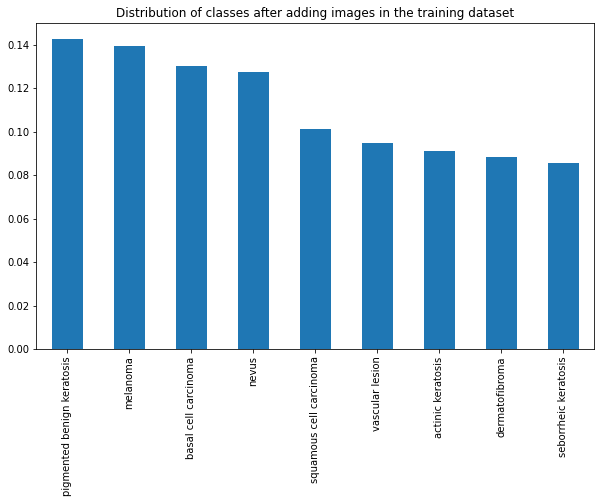

In [47]:
# Lets check distribution of classes after adding images in the training dataset
plt.figure(figsize = (10, 6))
df_dist3.plot(kind = 'bar')
plt.title("Distribution of classes after adding images in the training dataset")
plt.show()

#### **Findings:**
#### From above class distribution we can see that 
- Now we have added 500 images to all the classes to maintain some class balance.

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## Train the model on the data created using Augmentor

In [48]:
batch_size = 32
img_height = 180
img_width = 180

### Create a training dataset

In [49]:
data_dir_train = pathlib.Path(train_path)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Create a validation dataset

In [50]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Creating the model

In [51]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [52]:
### Your code goes here
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.20),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.20),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes)
])

### Compiling the model

In [53]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 45, 45, 64)       

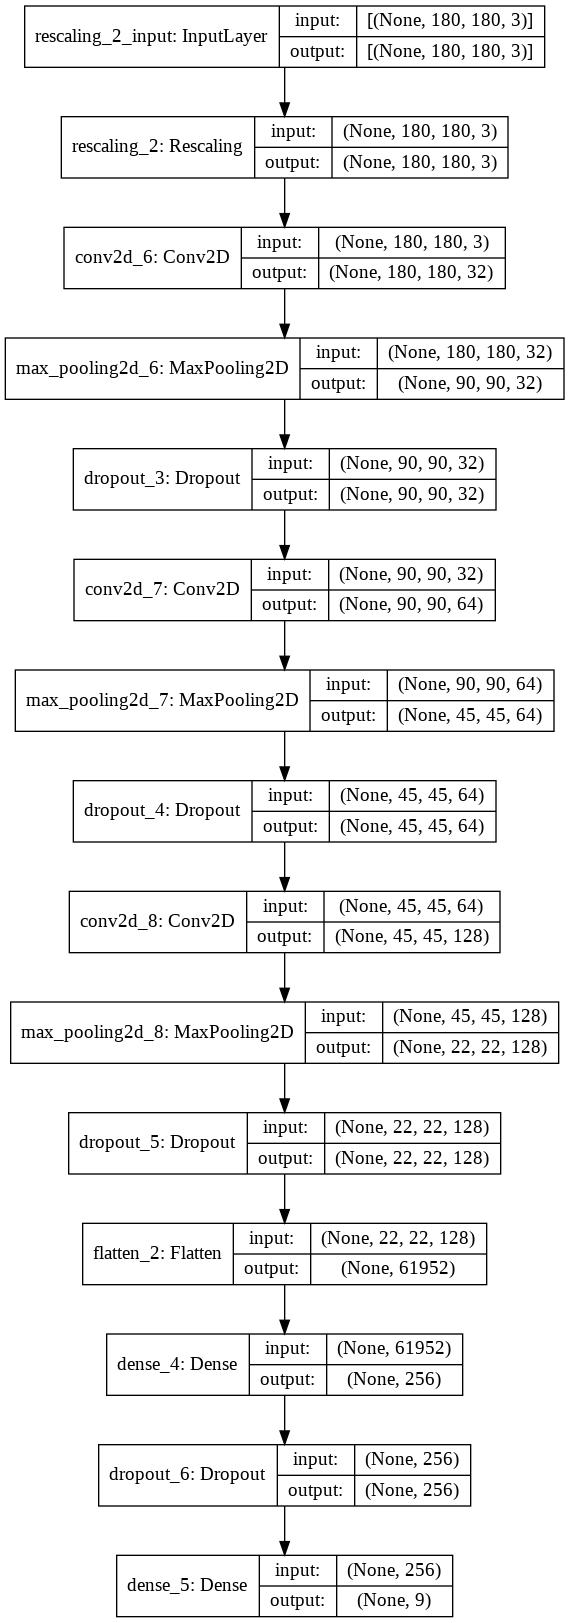

In [55]:
plot_model(model, show_shapes=True, show_layer_names=True)

### Training the model

In [56]:
%%time
## Your code goes here, use 30 epochs.
epochs = 30
history_3 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 53s 128ms/step - loss: 1.9519 - accuracy: 0.2847 - val_loss: 1.5132 - val_accuracy: 0.4736
Epoch 2/30
169/169 [==============================] - 14s 81ms/step - loss: 1.4541 - accuracy: 0.4588 - val_loss: 1.2685 - val_accuracy: 0.5330
Epoch 3/30
169/169 [==============================] - 14s 80ms/step - loss: 1.2597 - accuracy: 0.5356 - val_loss: 1.1208 - val_accuracy: 0.5805
Epoch 4/30
169/169 [==============================] - 14s 81ms/step - loss: 1.1080 - accuracy: 0.5888 - val_loss: 1.0188 - val_accuracy: 0.6377
Epoch 5/30
169/169 [==============================] - 14s 80ms/step - loss: 0.9754 - accuracy: 0.6469 - val_loss: 1.0856 - val_accuracy: 0.6110
Epoch 6/30
169/169 [==============================] - 14s 80ms/step - loss: 0.9087 - accuracy: 0.6612 - val_loss: 0.9121 - val_accuracy: 0.6875
Epoch 7/30
169/169 [==============================] - 14s 80ms/step - loss: 0.7805 - accuracy: 0.7133 - val_loss: 0.8136 - val_accuracy

### Visualize the model results

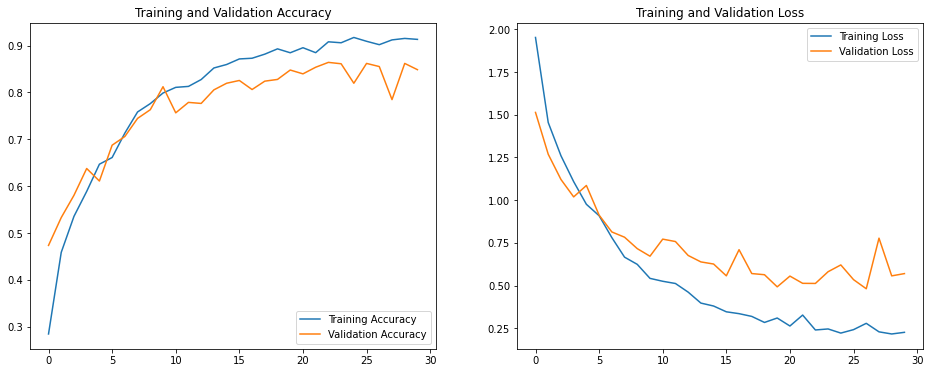

In [57]:
# call function to plot graph
visualize_train_result(history_3, epochs)

### Findings

#### In the plots above, the training and validation accuracy is increasing linearly over time. Model is performing well on training and validation set (model has achieved only around 91% accuracy on the training set and 84% accuracy on the validation set). 
#### Here we get rid of underfitting/overfitting.